# About Dataset

The dataset contains EEG signals from 11 subjects with labels of alert and drowsy. It can be opened with Matlab. We extracted the data for our own research purpose from another public dataset:

Cao, Z., et al., Multi-channel EEG recordings during a sustained-attention driving task. Scientific data, 2019. 6(1): p. 1-8.

If you find the dataset useful, please give credits to their works.

The details on how the data were extracted are described in our paper:

"Jian Cui, Zirui Lan, Yisi Liu, Ruilin Li, Fan Li, Olga Sourina, Wolfgang Müller-Wittig, A Compact and Interpretable Convolutional Neural Network for Cross-Subject Driver Drowsiness Detection from Single-Channel EEG, Methods, 2021, ISSN 1046-2023, https://doi.org/10.1016/j.ymeth.2021.04.017."

The codes of the paper above are accessible from:

https://github.com/cuijiancorbin/A-Compact-and-Interpretable-Convolutional-Neural-Network-for-Single-Channel-EEG

The data file contains 3 variables and they are EEGsample, substate and subindex.

"EEGsample" contains 2022 EEG samples of size 20x384 from 11 subjects. Each sample is a 3s EEG data with 128Hz from 30 EEG channels.
"subindex" is an array of 2022x1. It contains the subject indexes from 1-11 corresponding to each EEG sample.
"substate" is an array of 2022x1. It contains the labels of the samples. 0 corresponds to the alert state and 1 correspond to the drowsy state.

The unbalanced version of this dataset is accessible from:
https://figshare.com/articles/dataset/EEG_driver_drowsiness_dataset_unbalanced_/16586957

# Reference: Siamese Networks - Few Shot Learning

https://github.com/akshaysharma096/Siamese-Networks/blob/master/Few%20Shot%20Learning%20-%20V1.ipynb

https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d

https://neptune.ai/blog/understanding-few-shot-learning-in-computer-vision

# Siamese Networks

Siamese network is a Deep Nueral Network architecture proposed by Gregory et. al in his paper Siamese Neural Networks for One-shot Image Recognition, the paper proposes an architecture where using Convolutional Nueral Networks one can tackle the problem of One Shot Learning.

The model aims to solve the basic problem of image verification, given that we have very few samples of image of each class or category

The models aims to learn the embeddings of 2 separate images fed into the Nueral Network, the two embeddings are used to calculate the L1 distance between the 2 embeddings. Once the distance embedding metric is calculated, the embedding is fed into a sigmoid unit which by the magic of back propogation, learns the correct set of hyperparameters to carry out the image verification.

In [2]:
import tensorflow as tf 
print(tf.config.list_physical_devices('GPU'))

TypeError: Unable to convert function return value to a Python type! The signature was
	() -> handle

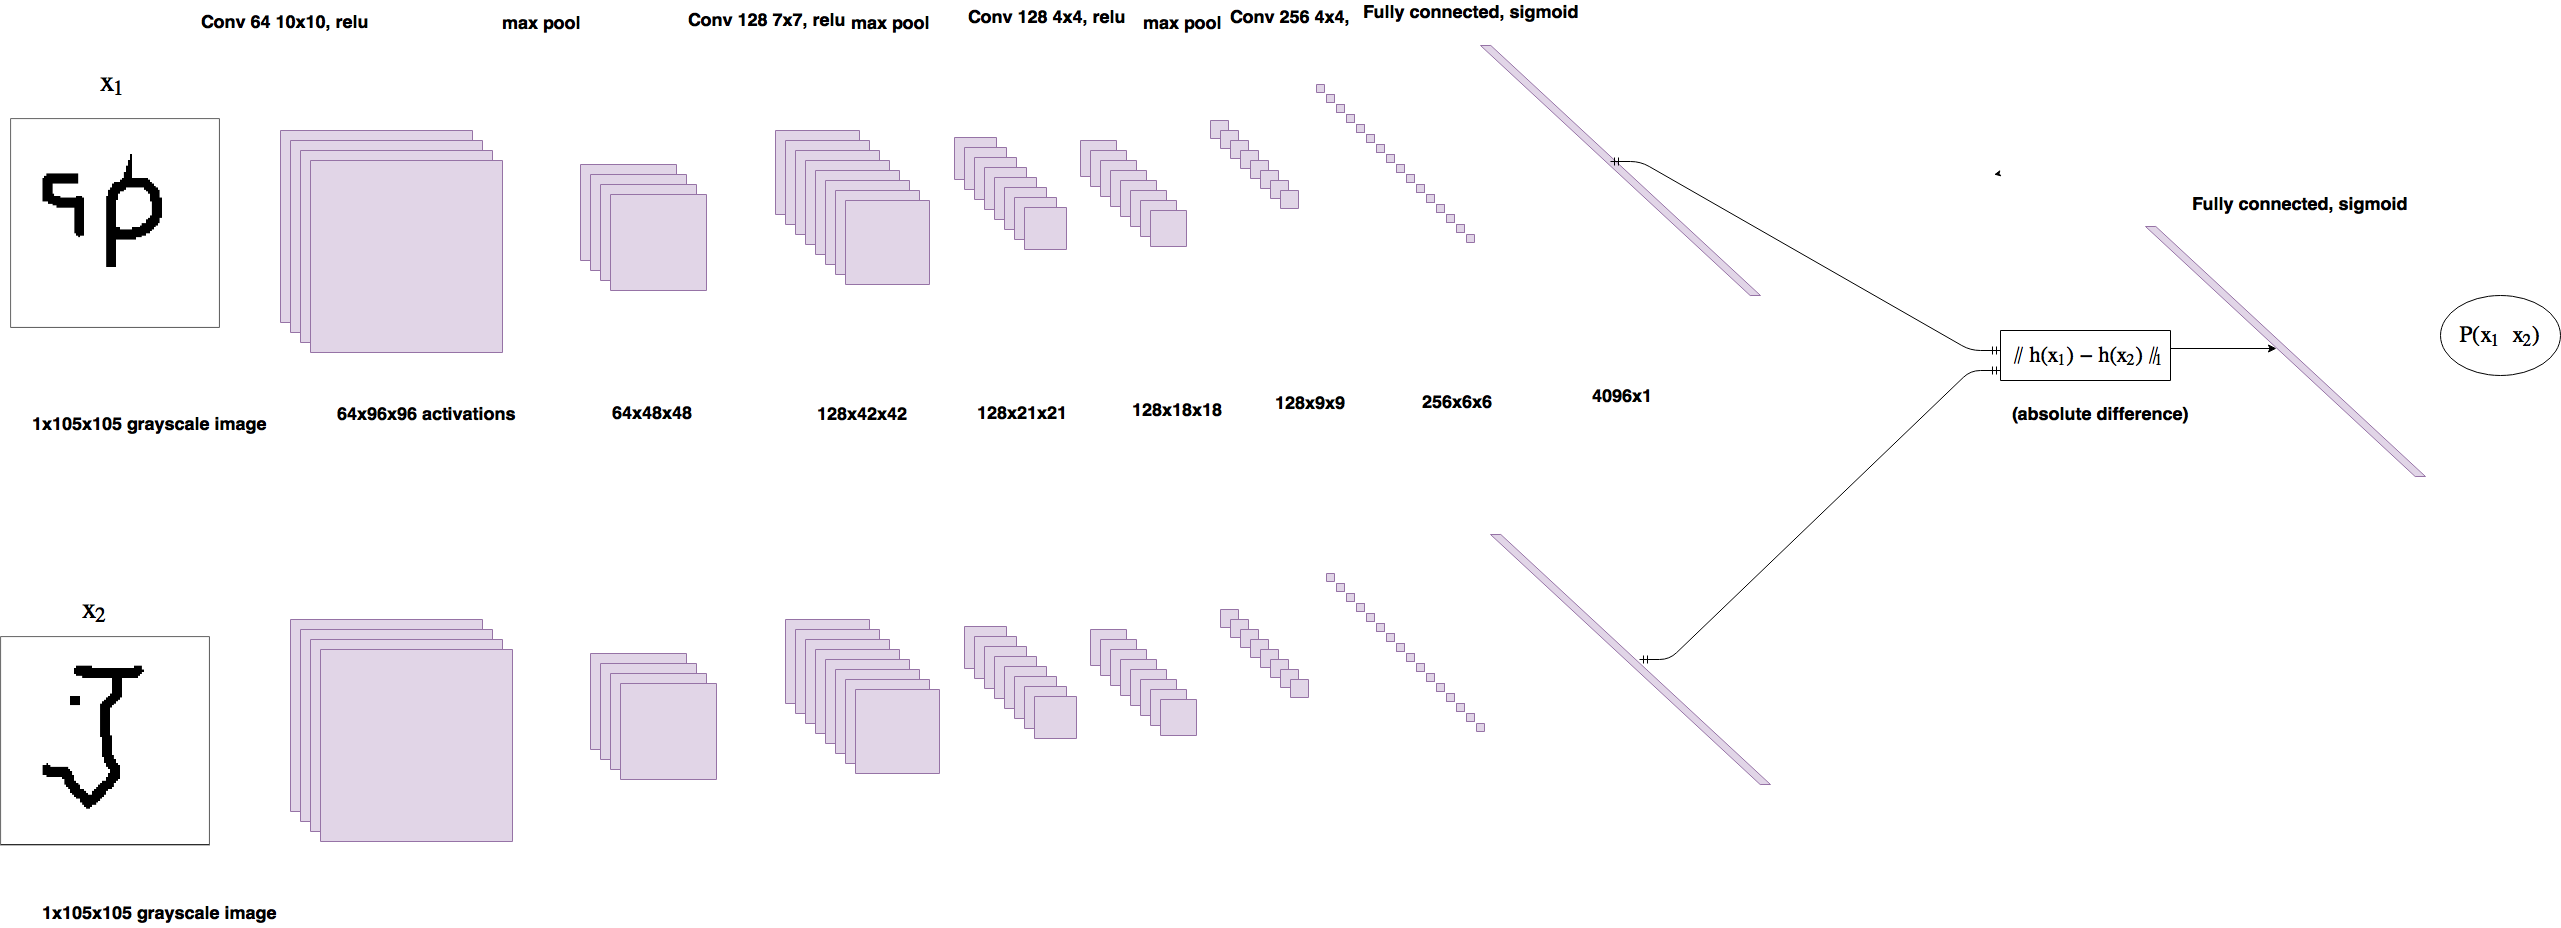

In [1]:
from IPython.display import Image, display

image_path = 'Image - Siamese Networks.png'
display(Image(filename=image_path))

The model of Siamese network can be described as CNN architecture with 2 arms, a right arm and a left arm. The CNN architecture of a single arm has 9 layers, including Max Pooling and Convolutional layers of different filter sizes, as described in the paper. These 9 layers work as feature selectors for the CNN architecture. Convolutional layers are initialized with weights having 0 mean 0.01 standard deviation, also the bias hyperparameter of the these layers is initialized with a mean value of 0.5 and a standard deviation of 0.01.

The basic intuition that once can gain from the paper is that it uses the L1 distance between the pixels of 2 different images as a metric of similarity.

If 2 images are similar the L1 distance between them will be lower as compared to the L1 distance computed for 2 somewhat different images.
The L1 distance computed is then used to train the sigmoid unit to find the write set of hyperparameters.

#  Importing Necessary Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from random import randint
from sklearn.utils import shuffle
import time
from keras.models import Sequential, Model
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Lambda
from keras.regularizers import l2
import keras.backend as K

#  Loading Data

In [3]:
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

In [4]:
# Display dataset shapes
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(621158, 5)
(621158,)
(155290, 5)
(155290,)


# Initialize Weights and Biases

In [5]:
def initialize_weights(shape, dtype=None):
    return RandomNormal(mean=0.0, stddev=0.01, seed=None)(shape, dtype=dtype)

def initialize_bias(shape, dtype=None):
    return RandomNormal(mean=0.5, stddev=0.01, seed=None)(shape, dtype=dtype)

#  Model Architecture

In [6]:
def get_siamese_model(input_shape):
    """
    Model architecture inspired by: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    model = Sequential()
    model.add(Conv1D(64, 2, activation='relu', input_shape=input_shape,
                     kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4), padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(128, 2, activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4), padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(128, 2, activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4), padding='same'))
    model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(Conv1D(256, 2, activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4), padding='same'))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                    kernel_regularizer=l2(1e-3),
                    kernel_initializer=initialize_weights, bias_initializer=initialize_bias))
    
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    L1_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    prediction = Dense(1, activation='sigmoid', bias_initializer=initialize_bias)(L1_distance)
    
    siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)
    return siamese_net

# Model summary
input_shape = (5, 1)
model = get_siamese_model(input_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 1)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 5, 1)]       0           []                               
                                                                                                  
 sequential (Sequential)        (None, 4096)         1168064     ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 4096)         0           ['sequential[0][0]',         

# Compile model

In [7]:
optimizer = Adam(learning_rate=0.001)
model.compile(loss="binary_crossentropy", optimizer=optimizer)

# Data Loader Class for Siamese network

In [8]:
class Siamese_Loader:
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

    def get_batch(self, batch_size, s="train"):
        X = self.X_train if s == "train" else self.X_test
        y = self.y_train if s == "train" else self.y_test

        pairs = [np.zeros((batch_size, X.shape[1], 1)) for _ in range(2)]
        targets = np.zeros((batch_size,))
        targets[batch_size // 2:] = 1

        for i in range(batch_size):
            idx1 = np.random.randint(0, len(X))
            pairs[0][i, :, 0] = X[idx1]
            if i >= batch_size // 2:
                idx2 = np.where(y == y[idx1])[0][np.random.randint(0, np.sum(y == y[idx1]))]
            else:
                idx2 = np.where(y != y[idx1])[0][np.random.randint(0, np.sum(y != y[idx1]))]
            pairs[1][i, :, 0] = X[idx2]

        return pairs, targets

    def generate(self, batch_size, s="train"):
        while True:
            pairs, targets = self.get_batch(batch_size, s)
            yield pairs, targets

    def make_oneshot_task(self, N, s="val"):
        X = self.X_test if s == "val" else self.X_train
        y = self.y_test if s == "val" else self.y_train

        true_category = np.random.randint(0, len(X) - 1)
        indices = np.random.randint(0, len(X), size=N)

        test_image = np.asarray([X[true_category]] * N).reshape(N, X.shape[1], 1)
        support_set = X[indices].reshape(N, X.shape[1], 1)

        targets = np.zeros((N,))
        targets[0] = 1

        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image, support_set]
        return pairs, targets

    def test_oneshot(self, model, N, k, s="val", verbose=0):
        n_correct = 0
        for _ in range(k):
            pairs, targets = self.make_oneshot_task(N, s)
            probs = model.predict(pairs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct += 1
        return 100.0 * n_correct / k

# Initialize data loader
loader = Siamese_Loader(X_train, y_train, X_test, y_test)

# Training parameters

In [9]:
evaluate_every = 10
loss_every = 20
batch_size = 1024
n_iter = 20
N_way = 20
n_val = 250
best = -1

# Training loop

In [10]:
# Training loop
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()

for i in range(1, n_iter + 1):
    inputs, targets = loader.get_batch(batch_size)
    loss = model.train_on_batch(inputs, targets)
    print(f"Iteration {i}/{n_iter}, Loss: {loss:.4f}")

    if i % evaluate_every == 0:
        print(f"Time for {i} iterations: {time.time() - t_start:.2f} seconds")
        val_acc = loader.test_oneshot(model, N_way, n_val, s="val", verbose=True)
        if val_acc >= best:
            print(f"Current best: {val_acc:.2f}%, Previous best: {best:.2f}%")
            model.save_weights('best_weights.h5')
            best = val_acc

    if i % loss_every == 0:
        print(f"Iteration {i}, training loss: {loss:.4f}")

# Load best model weights
model.load_weights('best_weights.h5')

Starting training process!
-------------------------------------
Iteration 1/20, Loss: 0.8319
Iteration 2/20, Loss: 0.8179
Iteration 3/20, Loss: 0.8047
Iteration 4/20, Loss: 0.7929
Iteration 5/20, Loss: 0.7823
Iteration 6/20, Loss: 0.7731
Iteration 7/20, Loss: 0.7651
Iteration 8/20, Loss: 0.7583
Iteration 9/20, Loss: 0.7525
Iteration 10/20, Loss: 0.7476
Time for 10 iterations: 22.53 seconds
1/1 [==============================] - 0s 22ms/step
Current best: 4.80%, Previous best: -1.00%
Iteration 11/20, Loss: 0.7435
Iteration 12/20, Loss: 0.7401
Iteration 13/20, Loss: 0.7373
Iteration 14/20, Loss: 0.7349
Iteration 15/20, Loss: 0.7330
Iteration 16/20, Loss: 0.7314
Iteration 17/20, Loss: 0.7301
Iteration 18/20, Loss: 0.7290
Iteration 19/20, Loss: 0.7281
Iteration 20/20, Loss: 0.7273
Time for 20 iterations: 58.52 seconds
1/1 [==============================] - 0s 23ms/step
Iteration 20, training loss: 0.7273


# Evaluate model on test data

In [11]:
test_inputs = loader.X_test
test_targets = loader.y_test

# Creating pairs for the entire test set
pairs = [np.zeros((len(test_inputs), test_inputs.shape[1], 1)) for _ in range(2)]
for i in range(len(test_inputs)):
    pairs[0][i, :, 0] = test_inputs[i]
    pairs[1][i, :, 0] = test_inputs[i]

# Make predictions
predictions = model.predict(pairs)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_targets

# Compute metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted', zero_division=1)
recall = recall_score(true_classes, predicted_classes, average='weighted', zero_division=1)
f1 = f1_score(true_classes, predicted_classes, average='weighted', zero_division=1)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report
class_report = classification_report(true_classes, predicted_classes, zero_division=1)
print("Classification Report:")
print(class_report)

4853/4853 [==============================] - 11s 2ms/step
Accuracy: 0.5002
Precision: 0.7500
Recall: 0.5002
F1 Score: 0.3336
Confusion Matrix:
[[77676     0]
 [77614     0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     77676
           1       1.00      0.00      0.00     77614

    accuracy                           0.50    155290
   macro avg       0.75      0.50      0.33    155290
weighted avg       0.75      0.50      0.33    155290

